In [1]:
import pickle
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import colorcet
import seaborn as sns
from nltk import FreqDist
from sklearn.decomposition import KernelPCA
from pyemd import emd_samples
from pyemd import emd


In [2]:
with open("../data/concs_labeled_min.pickle", "rb") as f:
    concs_labeled = pickle.load(f)

In [3]:
concs = [conc[0] for conc in concs_labeled]
labels = [conc[1] for conc in concs_labeled]
years =  [int(conc[2]) for conc in concs_labeled]

In [4]:
%%time
w2v = api.load('word2vec-google-news-300')

CPU times: user 22.7 s, sys: 1.11 s, total: 23.8 s
Wall time: 24.4 s


In [6]:
len(w2v.index_to_key)

3000000

In [9]:
vocab_counts = FreqDist([w for conc in concs for w in conc]).most_common()
vocab = [tup[0] for tup in vocab_counts]

In [10]:
w2v.index_to_key
w2v_filtered = Word2Vec()

In [11]:
w2v.index_to_key

['</s>',
 'in',
 'for',
 'that',
 'is',
 'on',
 '##',
 'The',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are',
 'I',
 'have',
 'he',
 'will',
 'has',
 '####',
 'his',
 'an',
 'this',
 'or',
 'their',
 'who',
 'they',
 'but',
 '$',
 'had',
 'year',
 'were',
 'we',
 'more',
 '###',
 'up',
 'been',
 'you',
 'its',
 'one',
 'about',
 'would',
 'which',
 'out',
 'can',
 'It',
 'all',
 'also',
 'two',
 'after',
 'first',
 'He',
 'do',
 'time',
 'than',
 'when',
 'We',
 'over',
 'last',
 'new',
 'other',
 'her',
 'people',
 'into',
 'In',
 'our',
 'there',
 'A',
 'she',
 'could',
 'just',
 'years',
 'some',
 'U.S.',
 'three',
 'million',
 'them',
 'what',
 'But',
 'so',
 'no',
 'like',
 'if',
 'only',
 'percent',
 'get',
 'did',
 'him',
 'game',
 'back',
 'because',
 'now',
 '#.#',
 'before',
 'company',
 'any',
 'team',
 'against',
 'off',
 'This',
 'most',
 'made',
 'through',
 'make',
 'second',
 'state',
 'well',
 'day',
 'season',
 'says',
 'w

In [12]:
w2v_filtered = KeyedVectors(vector_size=300)
vocab_filtered = []
# Iterate over the original KeyedVectors object
for word in vocab:
    try:
        w2v_filtered[word] = w2v[word]
        vocab_filtered.append(word)
    except:
        pass

In [13]:
len(vocab_filtered)

7513

In [14]:
def return_vectors(word_list, keyed_vectors):
    vocab_set = set(keyed_vectors.index_to_key)

    """
    replace words by vectors, while omitting missing words
    """
    word_list_filtered = list(set(word_list) & vocab_set)
    return [keyed_vectors[word] for word in word_list_filtered]

In [15]:
%%time
concs_vectors =  [return_vectors(conc, w2v_filtered) for conc in concs]

CPU times: user 1.48 s, sys: 36 ms, total: 1.52 s
Wall time: 1.57 s


In [16]:
len(concs_vectors)

7915

(array([  16.,   38.,   53.,  130.,  253.,  432.,  791., 1155., 1623.,
        1692., 1207.,  508.,    0.]),
 array([ 7.5,  8.5,  9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5,
        18.5, 19.5, 20.5]),
 <BarContainer object of 13 artists>)

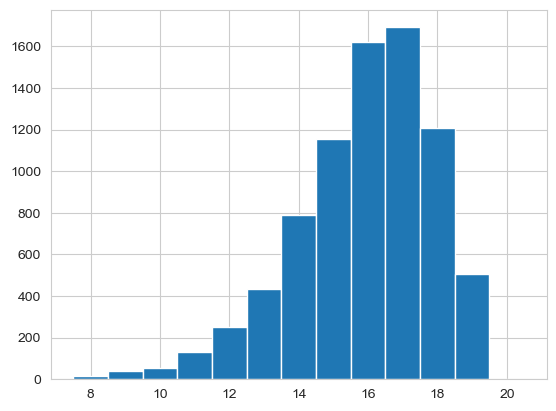

In [17]:
concs_vectors_lens = [len(conc) for conc in concs_vectors]
plt.hist(concs_vectors_lens, bins=[n+0.5 for n in range(7,21)])

In [18]:
vect = CountVectorizer(vocabulary=vocab_filtered, lowercase=False)
W_ = np.array([w2v_filtered[w] for w in vect.get_feature_names_out() if w in w2v_filtered.index_to_key])
D_ = euclidean_distances(W_).astype('float64')
D_ /= D_.max()  # just for comparison purposes
D_.shape

(7513, 7513)

In [19]:
concs_bows = vect.fit_transform([" ".join(conc) for conc in concs])
concs_bows = np.array([bow.toarray().ravel() for bow in concs_bows])
concs_bows.shape

(7915, 7513)

In [20]:
concs_bows_norm = [(bow / bow.sum()) for bow in concs_bows]

In [21]:
t1 = concs_bows_norm[10]
t2 = concs_bows_norm[20]

In [22]:
%%time
emd(t1, t2, D_)

CPU times: user 2.14 s, sys: 479 ms, total: 2.62 s
Wall time: 2.8 s


0.2753127085980004

In [23]:
# create a NumPy array of concatenated sentences
concs_array = np.array(concs, dtype=object)

# create an empty NumPy array of the correct size
distance_matrix = np.zeros((len(concs_array), len(concs_array)))

In [24]:
# use a nested for loop to calculate the WMD distance between each pair of sentences
for i in range(len(concs_array)):
    if i in range(0, len(concs_array), 100):
        print(i)
    for j in range(len(concs_array)):
        distance_matrix[i, j] = w2v_filtered.wmdistance(concs_array[i], concs_array[j])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900


In [25]:
distance_matrix.shape

(7915, 7915)

In [26]:
with open("../data/large_data/distance_matrix_min.pickle", "wb") as f:
    pickle.dump(distance_matrix, f)

In [4]:
#with open("../data/large_data/distance_matrix.pickle", "rb") as f:
#    distance_matrix = pickle.load(f)